In [245]:
# General useful imports
import array as ar
import contextlib
import wave
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Audio

from numpy import arange,linspace,mean, var, std, corrcoef, cov, transpose, ones,log,pi, sin, cos, exp, abs, angle, convolve
from numpy.random import random, randint, uniform
from scipy import signal
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.interpolate import UnivariateSpline

%matplotlib inline

# Basic parameters for reading and writing mono wave files

numChannels   = 1                      # mono
sampleWidth   = 2                      # in bytes, a 16-bit short
SR            = 44100                  #  sample rate
MAX_AMP       = (2**(8*sampleWidth - 1) - 1)    #maximum amplitude is 2**15 - 1  = 32767
MIN_AMP       = -(2**(8*sampleWidth - 1))       #min amp is -2**15
windowWidth   = 4410
windowSlide   = 2205


def round4(x):
    return np.around(x,4)

def round2(x):
    return np.around(x,2)

# Basic Numpy statistical functions

X = np.array([1,2,3])       # just an example
Y = np.array([4,5,6])
             
# mean of a list
mean(X)                            

# Clip a signal or a scalar to upper and lower bounds, if not specified, us
# bounds provided above; will change the array in place and return it.
# Does NOT make a new copy. 

def clip(X,lb=MIN_AMP,ub=MAX_AMP):
    
    if type(X) != list and type(X) != np.ndarray:
        return max(min(X,MAX_AMP),MIN_AMP)
    
    for k in range(len(X)):
        X[k] = max(min(X[k],MAX_AMP),MIN_AMP)
    return X

# To prevent clipping, this function takes a signal and scales it so the max amplitude
# is A; the result is coerced back into integers

def scaleSignal(X,A=MAX_AMP):
    s = A/max(X)
    return np.array( [ x*s for x in X ] ).astype(int)

# default is not to standardize the amplitude, if want scaled down or up set
# relative amp

def makeSignal(S=[(220,1,0)], amp=None, duration=1):
    X = np.zeros(int(SR*duration))  
    for (f,A,phi) in S:         
        X += [ (MAX_AMP * A) * np.sin( 2 * pi * f * k / SR + phi ) for k in range(len(X)) ]
    if amp == None:
        return X.astype(int) 
    else:
        return ((X / max(X)) * MAX_AMP * amp).astype(int) 
    
    
# some useful spectra    

def makeSpectrum(instr,freq=220):
    if(instr=="triangle"):
        return ([(freq,1.0,0.0),    
        (freq*3,-1/(9),0.0), 
        (freq*5,1/(25),0.0), 
        (freq*7,-1/(49),0.0), 
        (freq*9,1/(81),0.0), 
        (freq*11,-1/(121),0.0), 
        (freq*13,1/(13*13),0.0)])
    elif(instr=="square"):
        return ([(freq,2/(np.pi),0.0), 
        (freq*3,2/(3*np.pi),0.0), 
        (freq*5,2/(5*np.pi),0.0), 
        (freq*7,2/(7*np.pi),0.0), 
        (freq*9,2/(9*np.pi),0.0), 
        (freq*11,2/(11*np.pi),0.0), 
        (freq*13,2/(13*np.pi),0.0),
        (freq*15,2/(15*np.pi),0.0),
        (freq*17,2/(17*np.pi),0.0),
        (freq*19,2/(19*np.pi),0.0),
        (freq*21,2/(21*np.pi),0.0)])
    elif(instr=="clarinet"):
        return ([(freq,0.314,0.0), 
        (freq*3,.236,0.0), 
        (freq*5,0.157,0.0), 
        (freq*7,0.044,0.0), 
        (freq*9,0.157,0.0), 
        (freq*11,0.038,0.0), 
        (freq*13,0.053,0.0)] ) 
    elif(instr=="bell"):
        return ([(freq,0.1666,0.0), 
        (freq*2,0.1666,0.0), 
        (freq*3,0.1666,0.0), 
        (freq*4.2,0.1666,0.0), 
        (freq*5.4,0.1666,0.0), 
        (freq*6.8,0.1666,0.0)])  
    elif(instr=="steelstring"):
        return ([(freq*0.7272, .00278,0.0),
        (freq, .0598,0.0),
        (freq*2, .2554,0.0),
        (freq*3, .0685,0.0),
        (freq*4, .0029,0.0),
        (freq*5, .0126,0.0),
        (freq*6, .0154,0.0),
        (freq*7, .0066,0.0),
        (freq*8, .0033,0.0),
        (freq*11.0455, .0029,0.0),
        (freq*12.0455, .0094,0.0),
        (freq*13.0455, .0010,0.0),
        (freq*14.0455, .0106,0.0),
        (freq*15.0455, .0038,0.0)])
    elif(instr=='organ'):
        return ([(freq*1, 0.16042589643241895, 0.0),
        (freq*2, 0.1655, 0.0),
        (freq*3, 0.0015, 0.0),
        (freq*3.9949, 0.02161, 0.0),
        (freq*5.9949, 0.04552, 0.0),
        (freq*7.9949, 0.0324, 0.0),
        (freq*9.9899, 0.00242, 0.0),
        (freq*11.9898, 0.0045, 0.0),
        (freq*17.9847, 0.0057, 0.0),
        (freq*19.9796, 0.0011, 0.0),
        (freq*27.9745, 0.0008, 0.0),
        (freq*29.9745, 0.0016, 0.0)]        
        )
    else:
        return []

# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = ar.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(X,fname):
    X = clip(X)
    params = [1,2, SR , len(X), "NONE", None]
    data = ar.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")
    
# Display a graph of a signal

def displaySignal(X, left = 0, right = -1, minAmp=-1.2, maxAmp=1.2,title='Signal Window for X',signalRelative=False,xUnits = "Seconds", yUnits = "Relative",width=12, height=4):
    
    if(signalRelative):
        X = [x*MAX_AMP for x in X]
    minAmplitude = -(2**15 + 100)        # just to improve visibility of curve
    maxAmplitude = 2**15 + 300    
    
    if(xUnits == "Samples"):
        if(right == -1):
            right = len(X)
        T = range(left,right)
        Y = X[left:right]
    elif(xUnits == "Seconds"):
        if(right == -1):
            right = len(X)/44100
        T = np.arange(left, right, 1/44100)
        leftSampleNum = int(left*44100)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    elif(xUnits == "Milliseconds"):
        if(right == -1):
            right = len(X)/44.1
        T = np.arange(left, right, 1/44.1)
        leftSampleNum = int(left*44.1)
        Y = X[leftSampleNum:(leftSampleNum + len(T))]
    else:
        print("Illegal value for xUnits")
        
    if(yUnits == "Relative"):
        minAmplitude = minAmp            # just to improve visibility of curve
        maxAmplitude = maxAmp
        Y = [x/32767 for x in Y]

    fig = plt.figure(figsize=(width,height))   # Set x and y dimensions of window: may need to redo for your display
    fig.suptitle(title, fontsize=14, fontweight='bold')
    ax = plt.axes()
    if(xUnits=="Samples"):
        ax.set_xlabel("Sample Number")
    else:
        ax.set_xlabel(xUnits)
    ax.set_ylabel(yUnits + ' Amplitude')
    ax.set_ylim([minAmplitude,maxAmplitude])
    ax.set_xlim([left, right])
    plt.axhline(0, color='black')      # draw the 0 line in black
    plt.plot(T,Y) 
    if(    (xUnits == "Samples" and (right - left) < 101)
        or (xUnits == "Seconds" and (right - left) < 0.001)
        or (xUnits == "Milliseconds" and (right - left) < 1) ):
            plt.plot(T,Y, 'ro')                     
    plt.grid(True)                     # if you want dotted grid lines
    plt.show()
    
f = 10
T = np.arange(SR*1)
X = MAX_AMP * np.sin(2*pi*f*T/SR)

# displaySignal(X)

In [246]:
notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

Freqs['R'] = 0                    # a rest (silence) 

# test

Freqs['D4']

293.66476791740797

In [247]:
def realFFT(X):
    return 2*abs(np.fft.rfft(X))/len(X)

def spectrumFFT(X):
    R = np.fft.rfft(X)
    return [ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) for k in range(len(R)) ]

def findPeaksThreshold(A,threshold):      
    peaks = []
    for i in range (1,len(A)-1):
        if A[i-1] < A[i] and A[i+1] < A[i] and A[i] >= threshold:
            peaks.append((i,A[i]))
    return peaks

def findPeaksThreshold_new(A,threshold):      
    peaks = []
    for i in range (1,len(A)-1):
        if A[i-1] < A[i] and A[i+1] < A[i] and A[i] >= threshold:
            peaks.append((i,A[i]))
        elif np.abs(A[i] - A[i-1]) < 1.0 and A[i] >= threshold:
            # this is either a constant linear rise/fall in pitch over 2/10 of a second
            # or a momentary rest
            # I'm willing to bet its the latter
            peaks.append((i, A[i]))
    return peaks

def getSpectralPeaks(X,threshold):
    spect = realFFT(X)
    peaks = findPeaksThreshold(spect, threshold)
    
    clipped_spect = []
    for peak in peaks:
        component = (peak[0], peak[1], 0)
        clipped_spect.append(component)
        
    return clipped_spect

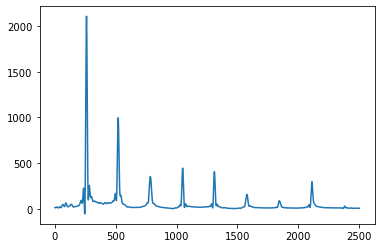

In [251]:
# use FFT to get the loudest pitch at any given point in time
from scipy.interpolate import InterpolatedUnivariateSpline

window_size = SR//10

cmaj = readWaveFile("cmaj.wav")
# cmaj = readWaveFile("cmaj3rds.wav")
# cmaj = readWaveFile("cjam.wav")
# cmaj = readWaveFile("cjam_noback.wav")
# cmaj = readWaveFile("sneacc.wav")

spectrum = spectrumFFT(cmaj[window_size*2:window_size*3])
freqs = [comp[0] for comp in spectrum]
amps = [comp[1] for comp in spectrum]
spl = InterpolatedUnivariateSpline(freqs, amps, k=4)
derivs = spl.derivative().roots()
t = np.linspace(1,2500,44100)
freq_graph = [spl(x) for x in t]
plt.plot(t, freq_graph)
# plt.xscale("log", basex=10)
# plt.plot(freqs, amps)
plt.show()
# print(spectrum)

In [252]:
tot = 0
tot_weight = 0
spectrum = [(220, 2400), (240, 1000), (3000, 50)]
for component in spectrum:
    tot += component[0] * component[1]
    tot_weight += component[1]
    
avg = tot / tot_weight

print(avg)

266.0869565217391


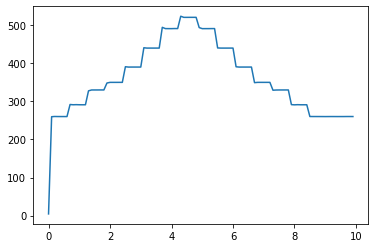

In [253]:
i = 0
t = []
loudestFreqs = []

while i < len(cmaj)-window_size:
    t.append(i)
    spectrum = spectrumFFT(cmaj[i:i+window_size])
    freqs = [comp[0] for comp in spectrum]
    amps = [comp[1] for comp in spectrum]
#     f = interp1d(freqs, amps, kind="quadratic")
#     if (i == window_size*4):
    spl = InterpolatedUnivariateSpline(freqs, amps, k=4)
#     print(spl(245.68668459))
#     print(optimize.root(f, [20,20]))
    minima_maxima = spl.derivative().roots()
    vals = spl(minima_maxima) # find values of func at min/maxima
    
    # append the largest local max
    loudestFreqs.append(minima_maxima[np.argmax(vals)])
    # we are appending the index of the max, 
    # which is the frequency of the highest amplitude
    
    i += window_size
    
# print(spectrumFFT(cmaj[window_size*3:window_size*4]))
# print(getSpectralPeaks(cmaj[window_size*3:window_size*4], 10))
# print(loudestFreqs[6])

t = [x/SR for x in t] # convert from samples to time

# print(loudestFreqs)
plt.plot(t, loudestFreqs)
plt.show()

Audio(cmaj, rate=SR)

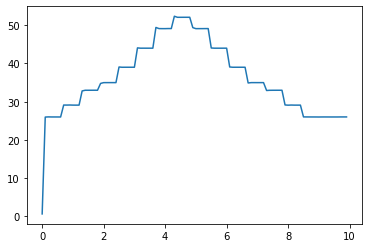

In [255]:
def parabolicInterpolationPeak(xs,ys):
#     print(xs,ys)
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    f = interp1d(xs,ys,kind='quadratic')
    x = -B / (2*A)
    return  (x,f(x))

i = 0
t = []
loudestFreqs = []

while i < len(cmaj)-window_size:
    t.append(i)
    spectrum = spectrumFFT(cmaj[i:i+window_size])
#     freqs = [comp[0] for comp in spectrum]
    amps = [comp[1] for comp in spectrum]
    max_point = np.argmax(amps)
    (max_freq, max_amps) = parabolicInterpolationPeak([max_point-1, max_point, max_point+1], [amps[max_point-1], amps[max_point], amps[max_point+1]])
    
    # append the largest local max
    loudestFreqs.append(max_freq)
    # we are appending the index of the max, 
    # which is the frequency of the highest amplitude
    
    i += window_size
    
# print(spectrumFFT(cmaj[window_size*3:window_size*4]))
# print(getSpectralPeaks(cmaj[window_size*3:window_size*4], 10))
# print(loudestFreqs[6])

t = [x/SR for x in t] # convert from samples to time

# print(loudestFreqs)
plt.plot(t, loudestFreqs)
plt.show()

Audio(cmaj, rate=SR)

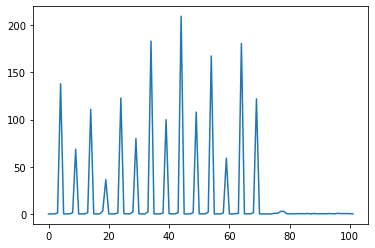

In [7]:
# get the derivative plot
# this shows when the notes change

deriv = np.abs(np.diff(loudestFreqs))

plt.plot(deriv)

In [8]:
peaks = findPeaksThreshold(deriv, 1)
print(peaks)
# plt.plot(peaks)

[(4, 138.04870737416036), (9, 68.67039207924552), (14, 110.85657061813015), (19, 36.40327096284625), (24, 122.82896797079559), (29, 79.90065522071598), (34, 183.18937833848122), (39, 99.92070492265793), (44, 209.590444103609), (49, 107.9539812889816), (54, 167.48246359936832), (59, 59.12425965284956), (64, 180.66325266267813), (69, 122.01709105670147), (78, 2.797944209628895)]


In [9]:
# get the ratio between each of the calculated note transition points

# this basically shows the musical intervals between each note in the
# perceived "melody"

transitions = []

for peak in peaks:
    pre = loudestFreqs[peak[0]-2]
    post = loudestFreqs[peak[0]+2]
    transitions.append(post/pre)
    
print(transitions)

print("Half step up:",2**(1/12))
print("Whole step up:",(2**(1/12))**2)
print("Half step down:",1/(2**(1/12)))
print("Whole step down:",1/((2**(1/12))**2))

print("Hey that looks pretty close!")

[1.2672420281014969, 0.8940238472409667, 1.1858892294355716, 0.9432688251073094, 1.18428719576193, 0.8951198508508322, 1.2588017245227563, 0.8874332669536217, 1.2665420081491128, 0.8896317469880225, 1.1924128126045774, 0.9426931876668696, 1.1825445217422974, 0.8969372464396679, 1.0008969968798114]
Half step up: 1.0594630943592953
Whole step up: 1.122462048309373
Half step down: 0.9438743126816934
Whole step down: 0.8908987181403393
Hey that looks pretty close!


In [10]:
# turn all that junk into a function

def createIntervalVector(song, window_size=SR//10):
    i = 0
    t = []
    loudestFreqs = []
    
    # TODO: figure out what the heck is wrong with this loop condition
    while i < len(song) - (window_size*3):
#         print(i)
        t.append(i)
        spectrum = spectrumFFT(cmaj[i:i+window_size])
        freqs = [comp[0] for comp in spectrum]
        amps = [comp[1] for comp in spectrum]
        spl = InterpolatedUnivariateSpline(freqs, amps, k=4)
        minima_maxima = spl.derivative().roots()
        vals = spl(minima_maxima) # find values of func at min/maxima
    
        # append the largest local max
        loudestFreqs.append(minima_maxima[np.argmax(vals)])
        # we are appending the index of the max, 
        # which is the frequency of the highest amplitude
    
        i += window_size
        
    deriv = np.abs(np.diff(loudestFreqs))
    
    peaks = findPeaksThreshold(deriv, 1)
    
    transitions = []

    for peak in peaks:
        pre = loudestFreqs[peak[0]-2]
        post = loudestFreqs[peak[0]+2]
        transitions.append(post/pre)
        
    return transitions

In [11]:
# input a melody in frequencies of notes and get the interval-vector

# NOTE: interval-vector is my working name for this concept
# maybe i can pivot to something catchy like... intervector...
# that's a little confusing though

# intervals are ordered going from previous to secondary note
# e.g. (C4,D4,E4) ==> ((C4->D4), (D4->E4))
def getIntervalVector(freqs):
    intervals = []
    for i in range(len(freqs)-1):
        intervals.append(freqs[i+1]/freqs[i])
        
    return intervals
        
melody = getIntervalVector([Freqs["D4"], Freqs["F4"], Freqs["E4"], Freqs["G4"]])

print(melody)

[1.1892071150027212, 0.9438743126816934, 1.1892071150027212]


The smallest difference between two ratios is $2^{\frac{2}{12}} - 2^{\frac{1}{12}}$
#TODO: come up with a better mathematical representation of this lol

So the detected ratio must be off by less than this amount to maintain integrity of detection while allowing for some approximation errors

In [148]:
# Now just compare the interval-vector of the desired melody
# to the interval-vector of the song! EZPZ 100% A++

# I'll define tolerence here to be the percentage of the above maximal difference
# to use as a threshold

# returns location of melody if found,
# -1 if not found
def melodyDetector(melody, song, tolerence=0.9):
    detection_threshold = tolerence * (2**(1/6) - 2**(1/12))
    
    for i in range(len(song)):
        # detect if first interval of melody appears in song at all
        if abs(melody[0] - song[i]) <= detection_threshold:
            # now see if the rest of the melody follows in sequence
            found_difference = False
            for j in range(1,len(melody)):
                if abs(melody[j] - song[i+j]) >= detection_threshold:
                    found_difference = True
                    break # or something
            # if flag wasn't tripped, melody was found
            if not found_difference:
                return i # return location of melody
    # if you got this far, the melody wasn't in there or I frikked up
    return -1

In [13]:
# It works!

print(melodyDetector(melody, transitions))

2


In [14]:
# Now to test it on some new stuff

In [15]:
cmaj3rds = readWaveFile("cmaj3rds.wav")

Audio(cmaj3rds, rate=SR)

In [16]:
interval_vector = createIntervalVector(cmaj3rds)

print(interval_vector)

melody_vector = getIntervalVector([Freqs["E5"], Freqs["D5"]])

print(melodyDetector(melody_vector, interval_vector))

[1.2672420281014969, 0.8940238472409667, 1.1858892294355716, 0.9432688251073094, 1.18428719576193, 0.8951198508508322, 1.2588017245227563, 0.8874332669536217, 1.2665420081491128, 0.8896317469880225, 1.1924128126045774, 0.9426931876668696, 1.1825445217422974, 0.8969372464396679, 1.0008969968798114]
1


In [150]:
# now to experiment with autocorrelation

# all imports from HW3

def corr(X,Y,normalize=True):    
    if normalize:
        X = X / (MAX_AMP/(2**(1/2)))
        Y = Y / (MAX_AMP/(2**(1/2)))
    return (X @ Y) / len(X)

def acorrK(X,k,normalize=True):
    N = len(X)
    return corr(X[:N-k], X[k:], normalize=normalize)


def acorr(X,normalize=True):
    N = len(X)
    
    if normalize:
        X = X / (MAX_AMP/(2**(1/2)))
        
    correlations = []
    
    for k in range(np.floor(N/2).astype(int)):
        correlations.append(acorrK(X, k, normalize=False))
        
    return correlations

def find_peaks(A,relative_threshold=0.75): 
    absolute_threshold = relative_threshold * max(A)    # or could assume highest value is at A[0]    
    peaks = []
    for t in range(3,len(A)-1):             
        if A[t-1] < A[t] and A[t] > A[t+1] and A[t] > absolute_threshold:
            peaks.append(t)
    return np.array(peaks)

def acorr_plot(X,relativeThreshold = 0.75, display=True):
    
    A = np.array(acorr(X))
    
    Xp = find_peaks(A, relative_threshold=relativeThreshold)
    Yp = [A[x] for x in Xp]

    if display:
        plt.figure(figsize=(12,4))
        plt.title("Signal X")
        plt.plot(X)
        plt.plot([0,len(X)],[0,0],color='k')
        plt.grid()
        plt.show()
        
        plt.figure(figsize=(12,4))
        plt.title("Autocorrelation Plot of X")
        plt.plot(A)
        plt.scatter(Xp,Yp,color='r')
        plt.plot([0,len(X)],[0,0],color='k')
        plt.grid()
        plt.show()
    
    
    return (A,Xp,Yp)

def acorr_pitch(X,relative_threshold=0.75,display=True):
    
    (A, Xp, Yp) = acorr_plot(X, relativeThreshold=relative_threshold, display=display)
    
    f0 = SR / Xp[0]
    period = SR/f0
    
    return (A,Xp,Yp,period,f0)

def parabolicInterpolationPeak(xs,ys):
#     print(xs,ys)
    [x1, x2, x3 ] = xs
    [y1, y2, y3 ] = ys
    denom = (x1 - x2) * (x1 - x3) * (x2 - x3)
    A     = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B     = (x3*x3 * (y1 - y2) + x2*x2 * (y3 - y1) + x1*x1 * (y2 - y3)) / denom
    f = interp1d(xs,ys,kind='quadratic')
    x = -B / (2*A)
    return  (x,f(x))

def acorr_pitch_interpolate(X,relative_threshold=0.75,display=True):

    (A, Xp, Yp) = acorr_plot(X, relativeThreshold=relative_threshold, display=display)
    
    (px, py) = parabolicInterpolationPeak([Xp[0]-1, Xp[0], Xp[0]+1], [A[Xp[0]-1], A[Xp[0]], A[Xp[0]+1]])
    
    f0 = SR/px
    
    period = SR/f0
    
    return (A,Xp,Yp,period,f0)

def get_pitch(X,relative_threshold=0.75):
    N = len(X)
    
    # just always normalize
    X = X / (MAX_AMP/(2**(1/2)))
        
    A = []
    peaks = []
    
    for k in range(np.floor(N/2).astype(int)):
        A.append(acorrK(X, k, normalize=False))
        
        peaks = find_peaks(A, relative_threshold=relative_threshold)
        
        if len(peaks) > 0:
            break
    
    # if no peaks were found above the threshold
    if len(peaks) == 0:
        return 0.0
    
    (px, py) = parabolicInterpolationPeak([peaks[0]-1, peaks[0], peaks[0]+1], [A[peaks[0]-1], A[peaks[0]], A[peaks[0]+1]])
    
#     plt.plot(A)
#     print (px)
        
    return SR/px

def get_pitch_plot(X, window_size=4410, overlap=0.5):
    i = 0
    pitch_plot = []
    while i < (len(X) - window_size):
        f = get_pitch(X[i:i+window_size], relative_threshold=0.75)
        pitch_plot.append(f)
        
        i += int(window_size*(1 - overlap))
        
    return pitch_plot

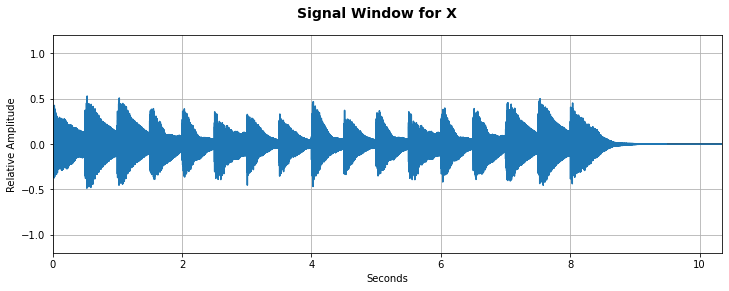

In [151]:
cmaj = readWaveFile("sneacc.wav")

displaySignal(cmaj)
Audio(cmaj, rate=SR)

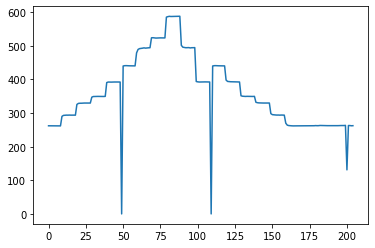

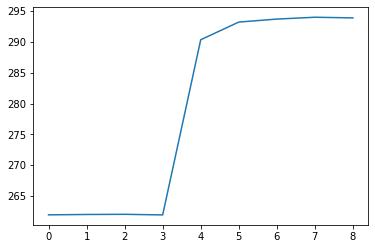

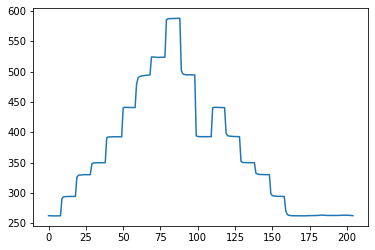

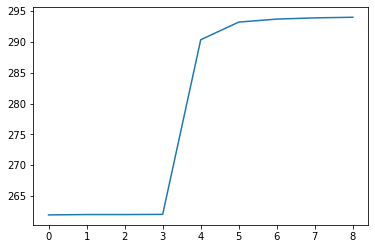

In [152]:
from scipy import signal

pitch_plot = get_pitch_plot(cmaj)

plt.plot(pitch_plot)
plt.show()

# zoomed in on first note transition
# pre filter
plt.plot(pitch_plot[5:14])
plt.show()

# do median filtering to remove sudden spikes in readings
pitch_plot = signal.medfilt(pitch_plot)
plt.plot(pitch_plot)
plt.show()

# zoomed in on first note transition
# post filter
plt.plot(pitch_plot[5:14])
plt.show()


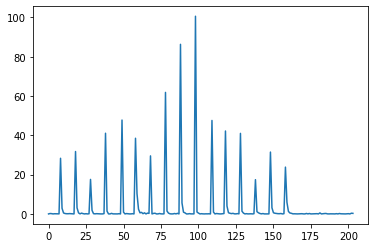

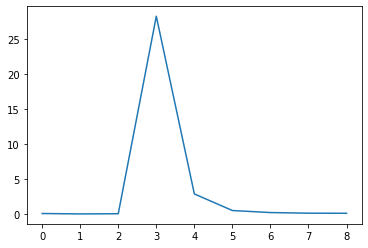

In [153]:
# get the derivative plot
# this shows when the notes change

deriv = np.abs(np.diff(pitch_plot))

plt.plot(deriv)
plt.show()

# zoomed in on first note transition
plt.plot(deriv[5:14])
plt.show()

In [154]:
peaks = findPeaksThreshold(deriv, 1)
print(peaks)
# plt.plot(peaks)

[(8, 28.312240982676713), (18, 31.75328441220273), (28, 17.555476987719544), (38, 41.054801299853295), (49, 47.767583249948245), (58, 38.49973946410438), (68, 29.531283085337805), (78, 61.83730048753239), (88, 86.30011283931685), (98, 100.59541373891392), (109, 47.558703877793164), (118, 42.1923925123059), (128, 40.984969334466996), (138, 17.430034574549495), (148, 31.474308348319994), (158, 23.81131612796412)]


In [155]:
# get the ratio between each of the calculated note transition points

transitions = []

for peak in peaks:
    pre = pitch_plot[peak[0]-2]
    post = pitch_plot[peak[0]+2]
    transitions.append(post/pre)
    
print(transitions)

print("Half step up:",2**(1/12))
print("Whole step up:",(2**(1/12))**2)
print("Half step down:",1/(2**(1/12)))
print("Whole step down:",1/((2**(1/12))**2))

print("Still looks good!")

[1.1190935679943268, 1.1185761627675879, 1.0589936901215609, 1.1218632440997314, 1.1236656863279681, 1.1104557234919268, 1.0611613237303634, 1.1209166686713592, 0.8441614224222279, 0.794662549101662, 1.1232724912022929, 0.89445797597727, 0.8916583253423669, 0.9465979435080769, 0.8952290348951347, 0.8984391895018343]
Half step up: 1.0594630943592953
Whole step up: 1.122462048309373
Half step down: 0.9438743126816934
Whole step down: 0.8908987181403393
Still looks good!


In [156]:
licc_Amin = getIntervalVector([Freqs["A4"], Freqs["B4"], Freqs["C5"], Freqs["D5"], Freqs["B4"], Freqs["G4"], Freqs["A4"]])

print(licc_Amin)

[1.122462048309373, 1.0594630943592953, 1.122462048309373, 0.8408964152537145, 0.7937005259840996, 1.1224620483093732]


In [157]:
melodyDetector(licc_Amin, transitions)

5

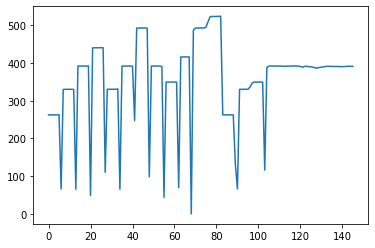

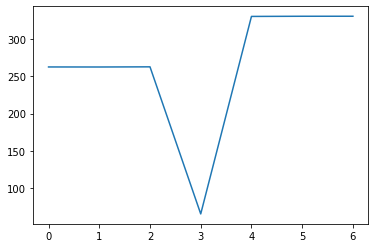

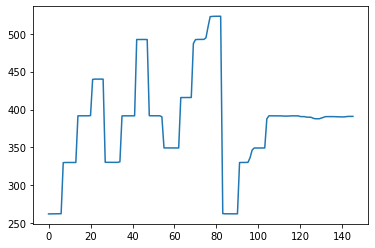

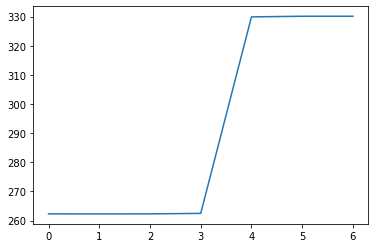

In [158]:
# Now do some filtering

cjam = readWaveFile("cjam_noback_synth.wav")

# plt.specgram(cjam, NFFT=1024,noverlap=512,Fs=SR,mode='magnitude',scale='linear')
# plt.show()

pitch_plot = get_pitch_plot(cjam)

plt.plot(pitch_plot)
plt.show()

# zoomed in on first note transition
# pre filter
plt.plot(pitch_plot[3:10])
plt.show()

# do median filtering to remove sudden spikes in readings
pitch_plot = signal.medfilt(pitch_plot, kernel_size=5) # window size of 5 works for this one
plt.plot(pitch_plot)
plt.show()

# zoomed in on first note transition
# post filter
plt.plot(pitch_plot[3:10])
plt.show()

Audio(cjam, rate=SR)

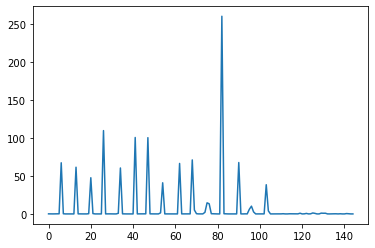

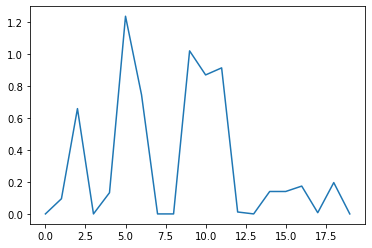

In [159]:
# get the derivative plot
# this shows when the notes change

deriv = np.abs(np.diff(pitch_plot))

plt.plot(deriv)
plt.show()

# zoomed in on first note transition
plt.plot(deriv[120:140])
plt.show()

So as you can see in the graph above, the small deviations in pitch as the last note is held create derivatives > 1. To make this more conistent, I should choose a peak threshold that at minimum grabs a change of a semitone, the smallest change in notes that could occur (with some approximation error forgiveness). For now I will just pick 1.5 lol

In [164]:
peaks1 = findPeaksThreshold(deriv, 1)
# print(peaks1)

peaks2 = findPeaksThreshold(deriv, 1.5)

peaks = peaks2

print(peaks)
print()
print("Extra peaks detected when using threshold of 1 instead of 1.5:\n", (list(set(peaks1) - set(peaks2))) )

[(6, 67.3804862294744), (13, 61.53927712336639), (20, 47.68130993903941), (26, 109.78210361024315), (34, 60.52994569750069), (41, 100.70859926645886), (47, 100.47266663515734), (54, 41.01702018670471), (62, 66.5040224945929), (68, 71.15218410492514), (75, 14.608895863440694), (82, 260.4433190870906), (90, 67.70656889353603), (96, 10.211202574946526), (103, 38.460794124397125)]

Extra peaks detected when using threshold of 1 instead of 1.5:
 [(125, 1.2353691590225253), (129, 1.0190210521715812)]


In [165]:
# get the ratio between each of the calculated note transition points

transitions = []

for peak in peaks:
    pre = pitch_plot[peak[0]-2]
    post = pitch_plot[peak[0]+2]
    transitions.append(post/pre)
    
print(transitions)

[1.258405112505406, 1.1866831455077764, 1.1235598218711096, 0.7504172603104114, 1.1860247829003074, 1.2572405327229612, 0.795483010497407, 0.8916284433003678, 1.1905273587252365, 1.1837184132419487, 1.06112259426125, 0.5016426770296726, 1.2582806695062987, 1.0575110759035609, 1.1216541250171785]


Below's an example of inputting specific notes but the detector found a spot that had a sequence with the same intervals between those notes, but that weren't playing those specific notes. I input $G_4-B_4-C_5$ (M3, m2) and it found $C_4-E_4-F_4$ (M3, m2).

In [166]:
melody = getIntervalVector([Freqs["G4"], Freqs["B4"], Freqs["C5"]])

print(melodyDetector(melody, transitions))

12


In [167]:
melody = getIntervalVector([Freqs["F4"], Freqs["Ab4"], Freqs["B4"], Freqs["C5"]])

print(melodyDetector(melody, transitions))

8


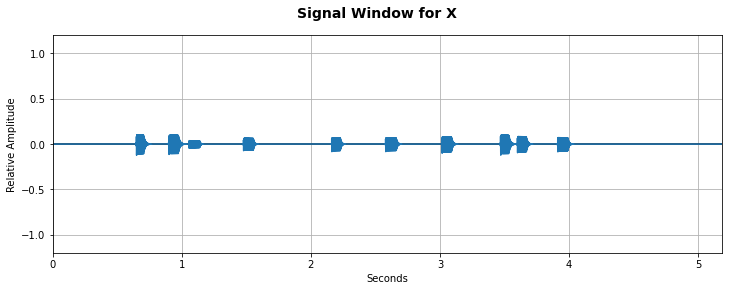

In [239]:
# Now something with rests

sans = readWaveFile("sans.wav")
# sans = readWaveFile("sans_short_fast.wav")
# sans = readWaveFile("sans_long_fast.wav")
# sans = readWaveFile("sans_short_slow.wav")
# sans = readWaveFile("sans_long_slow.wav")

sans = np.concatenate((sans, np.zeros(SR)))

displaySignal(sans)
Audio(sans, rate=SR)

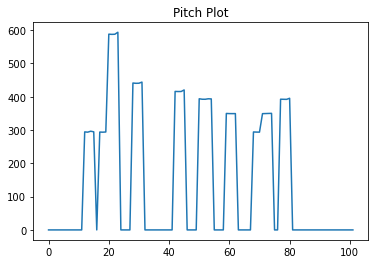

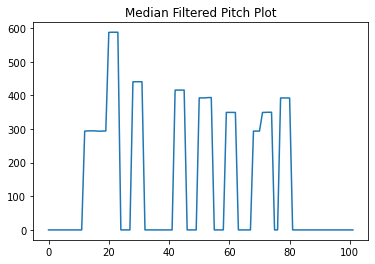

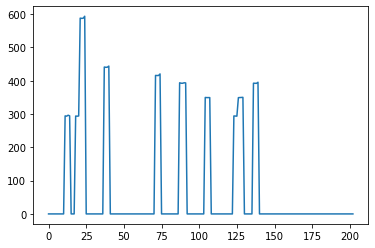

In [240]:
pitch_plot = get_pitch_plot(sans)

plt.plot(pitch_plot)
plt.title("Pitch Plot")
plt.show()

# zoomed in on first note transition
# pre filter
# plt.plot(pitch_plot[3:10])
# plt.show()

# do median filtering to remove sudden spikes in readings
# can't actually use this cause it could remove small rests in between repeated notes
pitch_plot_smoothed = signal.medfilt(pitch_plot, kernel_size=3)
plt.plot(pitch_plot_smoothed)
plt.title("Median Filtered Pitch Plot")
plt.show()

# exaggerate all 0 values for clearer note transition distinctions
pitch_plot_more_zeros = []

for pitch in pitch_plot:
    if pitch == 0.0:
        pitch_plot_more_zeros.extend([pitch,pitch,pitch])
    else:
        pitch_plot_more_zeros.append(pitch)

# print(pitch_plot_more_zeros)        

plt.plot(pitch_plot_more_zeros[25:250])
plt.show()

# pitch_plot = pitch_plot_more_zeros

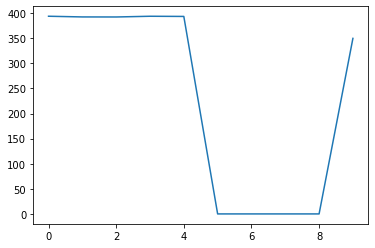

In [241]:
# zoomed in
# plt.plot(pitch_plot[90:98])
plt.plot(pitch_plot[50:60])
plt.show()

We're actually gonna use the unfiltered version this time, since I realized that rests are just drops to 0. It would be better to consider every drop to 0 a rest and to handle this later in processing, as there is no difference in terms of intervalic content between swithcing immediately to a new note and resting before switching to a new note.

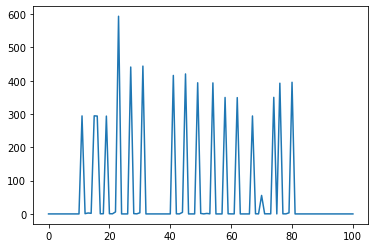

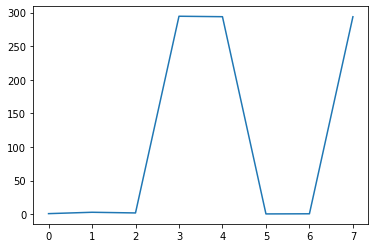

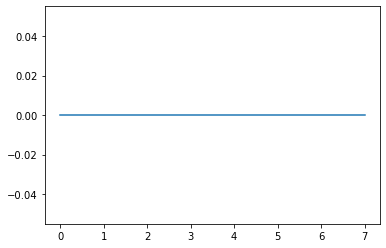

0.0 0.0 0.0


In [242]:
# get the derivative plot
# this shows when the notes change

deriv = np.abs(np.diff(pitch_plot))

plt.plot(deriv)
plt.show()

# zoomed in
plt.plot(deriv[12:20])
plt.show()

plt.plot(deriv[90:98])
plt.show()

print(deriv[92], deriv[93], deriv[94])

[(11, 294.39554038862144), (15, 294.60174541426085), (19, 293.8446606549172), (23, 593.7086175582684), (27, 441.1701898277541), (31, 443.9733611902118), (41, 415.9481985694137), (45, 420.41744510567526), (49, 393.88196716947795), (54, 393.50053095294015), (58, 349.77052884780306), (62, 349.36675202392115), (67, 294.2109479065121), (70, 55.541846529020404), (74, 350.10576853435555), (76, 392.59107702058657), (80, 395.40601469319176)]

Extra peaks detected when using threshold of 1 instead of 3:
 [(52, 1.4424826989213102), (13, 2.8231004660179906)]


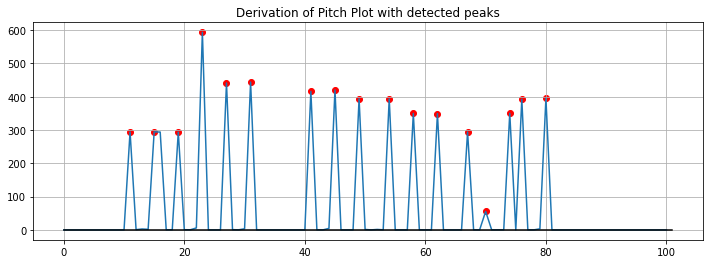

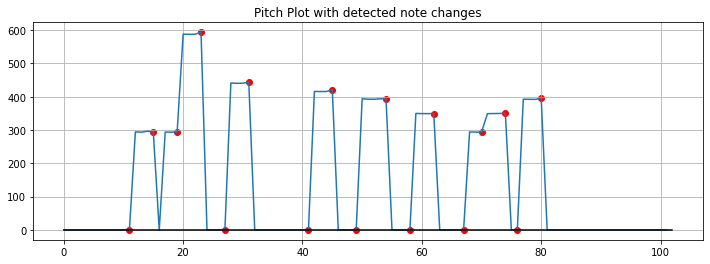

Values of pitch plot at note transitions:
[0.0, 294.60174541426085, 294.11568151482265, 593.7086175582684, 0.0, 443.9733611902118, 0.0, 420.41744510567526, 0.0, 393.50053095294015, 0.0, 349.36675202392115, 0.0, 293.66405895993074, 350.10576853435555, 0.0, 395.40601469319176]


In [243]:
peaks1 = findPeaksThreshold(deriv, 1)
# print(peaks1)

# had to increase the threshold even more this time
peaks2 = findPeaksThreshold(deriv, 3)

print(peaks2)
print()
print("Extra peaks detected when using threshold of 1 instead of 3:\n", (list(set(peaks1) - set(peaks2))) )

peaks = peaks2

plt.figure(figsize=(12,4))
plt.title("Derivation of Pitch Plot with detected peaks")
plt.plot(deriv)
plt.scatter([peak[0] for peak in peaks],[peak[1] for peak in peaks],color='r')
plt.plot([0,len(deriv)],[0,0],color='k')
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
plt.title("Pitch Plot with detected note changes")
plt.plot(pitch_plot)
plt.scatter([peak[0] for peak in peaks],[pitch_plot[peak[0]] for peak in peaks],color='r')
plt.plot([0,len(pitch_plot)],[0,0],color='k')
plt.grid()
plt.show()

freqs = [pitch_plot[peak[0]] for peak in peaks]
print("Values of pitch plot at note transitions:")
print(freqs)

Now we have to somehow deal with the rests. I've decided to deal with them in this step cause it seemd the most sensible way to do it.

In [244]:
# get the ratio between each of the calculated note transition points

transitions = []

peak_locations = [peak[0] for peak in peaks]

pre = pitch_plot[peak_locations[0] - 2]
post = 0
# this loop will be from the view point of the first note going to the second note (i is index of first note)
# thus, there is no need to consider the last 
for i in range (len(peak_locations)):
    peak = peak_locations[i]
    
    # make sure we aren't starting from a 0
    if pre == 0.0:
        # possible out of bounds
        peak = peak_locations[i+1]
        pre = pitch_plot[peak - 2]
        continue
    
    post = pitch_plot[peak + 2]
    # if post is silence then keep looking for the next note following a peak
    if post == 0.0:
        continue
    else:
        transitions.append(post/pre)
        if i == len(peak_locations):
            # last iteration
            break
        else:
            peak = peak_locations[i+1]
            pre = pitch_plot[peak - 2] 
    
print(np.array(transitions))
sans_melody = [Freqs["D4"], Freqs["D4"], Freqs["D5"], Freqs["A4"], Freqs["Ab4"], Freqs["G4"], Freqs["F4"], Freqs["D4"], Freqs["F4"], Freqs["G4"]]
sans_vector = getIntervalVector(sans_melody)
print(np.array(sans_vector))
print(melodyDetector(sans_vector[3:6], transitions))

[1.00105783 1.9982627  0.749744   0.94389564 0.94434475 0.89028154
 0.8410229  1.1878503  1.12260623]
[1.         2.         0.74915354 0.94387431 0.94387431 0.89089872
 0.84089642 1.18920712 1.12246205]
3


Something to note is that there was a momentary (one unit of sampled time) rest in between the first two notes. This was effectively skipped over due to reaching 2 units out from the peak for pre/post frequency picking. This shouldn't pose a significant problem, as a peak was still found at the end of the first of the two repeated notes due to there being a drop in frequency at all. In fact, more extended rests are essentially converted to this form using the if statement that checks if post is equal to 0.

The original reason for reaching 2 units out from the peak is that the frequency of the note might not be fully stable so close to the onset of the note. This momentary rest phenomenon may casue a loss of quality in the output because we are picking a frequency closer to the onset of a note, due to this skipping effect mentioned. But as long as it works in my testing I'm not super worried about it.

So I've gotten around this nuance by just extending all zero values. This should make behavior mor consistent while hopefully not impacting performance that much.